In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on

# Part ② - Exploratory analysis and clustering

## Table of contents
- <a href='#C0'>0. Importing libraries and dataframe</a>
- <a href='#C1'>1. Customers aggregation</a>
- <a href='#C2'>2. Exploratory analysis</a>
    - <a href='#C2.1'>2.1 Univariate analysis</a>
    - <a href='#C2.2'>2.2 Multivariate analysis</a>
- <a href='#C3'>3. RFM segmentation</a>
- <a href='#C4'>4. Selection of more features as an alternative to RFM</a>
    - <a href='#C4.1'>4.1 Sampling</a>
    - <a href='#C4.2'>4.2 Features selection</a>
    - <a href='#C4.3'>4.3 Normalization of selected variables</a>
    - <a href='#C4.4'>4.4 K-means clustering</a>
    - <a href='#C4.5'>4.5 Hierarchical clustering = Agglomerative clustering</a>
    - <a href='#C4.6'>4.6 DBScan clustering</a>
    - <a href='#C4.7'>4.7 Model selection and radar plot</a>
           

# <a name="C0">0. Importing libraries and dataframe</a>

In [439]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.cluster.hierarchy import dendrogram
from math import pi
from random import randrange
import time

import matplotlib.image as mpimg
import plotly.graph_objects as go
import plotly.express as px
import geopandas as gpd
import os
if not os.path.exists('images'):
    os.mkdir('images')

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, adjusted_rand_score,\
    davies_bouldin_score
from sklearn import decomposition
from sklearn import manifold
from sklearn.manifold import TSNE
import umap
import dataframe_image as dfi

In [381]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set_style("white")

In [382]:
df0 = pd.read_csv('cleaned.csv')

In [383]:
# Correcting data types

In [384]:
df0.head()

,customer_unique_id,customer_state,order_id,date_purchase,date_delivery,nb_of_items,freight_value,product_weight_g,product_volume,category,seller_state,seller_lat,seller_long,review_score,perc_credit,payment_installments,payment_value,customer_lat,customer_long,delivery_time
0,861eff4711a542e4b93843c6dd7febb0,Southeast,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2017-05-25 10:35:35,1.0,21.88,8683.0,107136.0,office,Southeast,-23.482623,-46.374490,4.0,1.0,2.0,146.87,-20.509898,-47.397866,8.0
1,290c77bc529b7ac935b93aa66c333dc3,Southeast,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,2018-01-29 12:41:19,1.0,46.48,10150.0,53400.0,furniture,South,-26.912429,-48.677381,5.0,1.0,8.0,335.48,-23.726853,-46.545746,16.0
2,060e732b5b29e8181a18229c7b0b2b5e,Southeast,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,2018-06-14 17:58:51,1.0,17.79,8267.0,45968.0,office,Southeast,-23.482623,-46.374490,5.0,1.0,7.0,157.73,-23.527788,-46.660310,26.0
3,259dac757896d24d7702b9acbbff3f3c,Southeast,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,2018-03-28 16:04:25,1.0,23.36,12160.0,79968.0,office,Southeast,-23.482623,-46.374490,5.0,1.0,1.0,173.30,-23.496930,-46.185352,14.0
4,345ecd01c38d18a9036ed96c73b8d066,Southeast,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,2018-08-09 20:55:48,1.0,22.25,5200.0,23625.0,furniture,Southeast,-21.766477,-48.831547,5.0,1.0,8.0,252.25,-22.987222,-47.151073,11.0


In [385]:
df0.date_purchase = pd.to_datetime(df0.date_purchase)
# df0.date_delivery = pd.to_datetime(df0.date_delivery)
# df0.review_score = df0.review_score.astype('category')

# <a name="C1">1. Customers aggregation</a>

In [386]:
# Considering the complete period of time

In [387]:
df0['recency'] = (df0['date_purchase'].max() - df0['date_purchase']).dt.days

<AxesSubplot:xlabel='recency', ylabel='recency'>

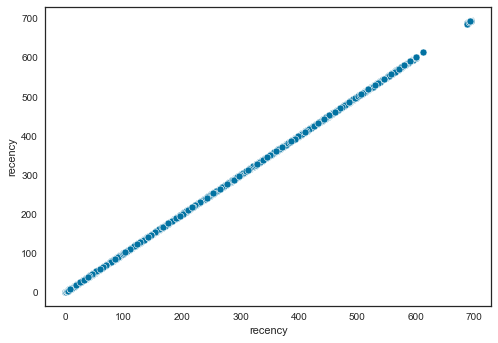

In [388]:
sns.scatterplot(x=df0['recency'], y=df0['recency'])

### Number of orders

In [389]:
df0.loc[:, 'nb_of_orders'] =\
    df0.groupby('customer_unique_id')['customer_unique_id']\
    .transform('count')

In [390]:
df0.head()

,customer_unique_id,customer_state,order_id,date_purchase,date_delivery,nb_of_items,freight_value,product_weight_g,product_volume,category,seller_state,seller_lat,seller_long,review_score,perc_credit,payment_installments,payment_value,customer_lat,customer_long,delivery_time,recency,nb_of_orders
0,861eff4711a542e4b93843c6dd7febb0,Southeast,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2017-05-25 10:35:35,1.0,21.88,8683.0,107136.0,office,Southeast,-23.482623,-46.374490,4.0,1.0,2.0,146.87,-20.509898,-47.397866,8.0,469,1
1,290c77bc529b7ac935b93aa66c333dc3,Southeast,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,2018-01-29 12:41:19,1.0,46.48,10150.0,53400.0,furniture,South,-26.912429,-48.677381,5.0,1.0,8.0,335.48,-23.726853,-46.545746,16.0,228,1
2,060e732b5b29e8181a18229c7b0b2b5e,Southeast,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,2018-06-14 17:58:51,1.0,17.79,8267.0,45968.0,office,Southeast,-23.482623,-46.374490,5.0,1.0,7.0,157.73,-23.527788,-46.660310,26.0,101,1
3,259dac757896d24d7702b9acbbff3f3c,Southeast,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,2018-03-28 16:04:25,1.0,23.36,12160.0,79968.0,office,Southeast,-23.482623,-46.374490,5.0,1.0,1.0,173.30,-23.496930,-46.185352,14.0,168,1
4,345ecd01c38d18a9036ed96c73b8d066,Southeast,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,2018-08-09 20:55:48,1.0,22.25,5200.0,23625.0,furniture,Southeast,-21.766477,-48.831547,5.0,1.0,8.0,252.25,-22.987222,-47.151073,11.0,31,1


In [391]:
df0.nb_of_orders.value_counts()

1     90548
2      5146
3       543
4       112
5        45
6        30
7        21
15       15
9         9
Name: nb_of_orders, dtype: int64

In [392]:
def mode(x): return stats.mode(x)[0] if len(x) > 1 else x


agg_dict = {
            'nb_of_orders': np.max,
            'customer_state': mode,
            'freight_value': np.sum,
            'perc_credit': np.mean,
            'payment_installments': np.mean,
            'payment_value': np.sum,
            'category': mode,
            'product_weight_g': np.mean,
            'product_volume': np.mean,
            'nb_of_items': np.mean,
            'review_score': np.mean,
            'date_purchase': np.max,
            'delivery_time': np.mean,
            }

In [393]:
df = df0.groupby('customer_unique_id').agg(agg_dict).reset_index()

In [394]:
# Binning nb_of_items into categories -> CANCELED

bins = [0, 1, 2, np.inf]
names = ['one', 'two', 'three or more']

df['nb_of_items'] = pd.cut(df['nb_of_items'], bins, labels=names)

In [395]:
# Considering the complete period of time

In [396]:
df['recency'] = (df['date_purchase'].max()
                 - df['date_purchase']).dt.days

<AxesSubplot:xlabel='recency', ylabel='recency'>

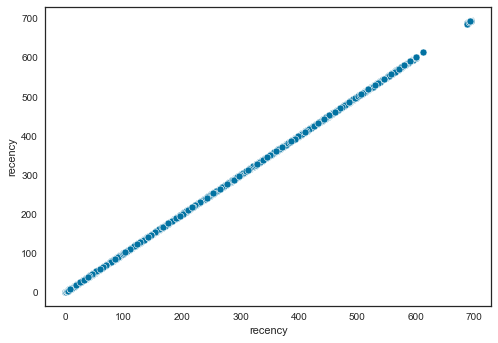

In [397]:
sns.scatterplot(x=df0['recency'], y=df0['recency'])

In [398]:
df.head()

,customer_unique_id,nb_of_orders,customer_state,freight_value,perc_credit,payment_installments,payment_value,category,product_weight_g,product_volume,nb_of_items,review_score,date_purchase,delivery_time,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,1,Southeast,12.00,1.0,8.0,141.90,furniture,1500.0,7616.0,1.0,5.0,2018-05-10 10:56:27,6.0,111
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,Southeast,8.29,1.0,1.0,27.19,hygiene,375.0,5148.0,1.0,4.0,2018-05-07 11:11:27,3.0,114
2,0000f46a3911fa3c0805444483337064,1,South,17.22,1.0,8.0,86.22,office,1500.0,43750.0,1.0,3.0,2017-03-10 21:05:03,25.0,536
3,0000f6ccb0745a6a4b88665a16c9f078,1,North,17.63,1.0,4.0,43.62,electronics,150.0,1045.0,1.0,4.0,2017-10-12 20:29:41,20.0,320
4,0004aac84e0df4da2b147fca70cf8255,1,Southeast,16.89,1.0,6.0,196.89,electronics,6050.0,528.0,1.0,5.0,2017-11-14 19:45:42,13.0,287


In [399]:
df.dtypes

customer_unique_id              object
nb_of_orders                     int64
customer_state                  object
freight_value                  float64
perc_credit                    float64
payment_installments           float64
payment_value                  float64
category                        object
product_weight_g               float64
product_volume                 float64
nb_of_items                    float64
review_score                   float64
date_purchase           datetime64[ns]
delivery_time                  float64
recency                          int64
dtype: object

# Renaming variables

In [400]:
df.rename(columns={'customer_unique_id': 'ID',
                   'nb_of_orders': 'frequency',
                   'payment_value': 'monetary',
                   'product_volume': 'product_volume_cm3',
                   'nb_of_items': 'mean_nb_of_items',
                   'review_score': 'mean_review_score',
                   'delivery_time': 'mean_delivery_time',
                   'payment_installments': 'mean_installments'
                   }, inplace=True)

In [401]:
df.columns

Index(['ID', 'frequency', 'customer_state', 'freight_value', 'perc_credit',
       'mean_installments', 'monetary', 'category', 'product_weight_g',
       'product_volume_cm3', 'mean_nb_of_items', 'mean_review_score',
       'date_purchase', 'mean_delivery_time', 'recency'],
      dtype='object')

# <a name="C2">2. Exploratory analysis</a>

## <a name="C2.1">2.1 Univariate analysis</a>

### 2.1.1 Numerical features

In [435]:
quant = ['freight_value',
         'monetary',
         'product_weight_g',
         'product_volume_cm3',
         'frequency',
         'recency',
         'mean_nb_of_items',
         'mean_review_score',
         'mean_delivery_time',
         'mean_installments',
         'perc_credit']

In [437]:
qual = ['customer_state',
        'category']

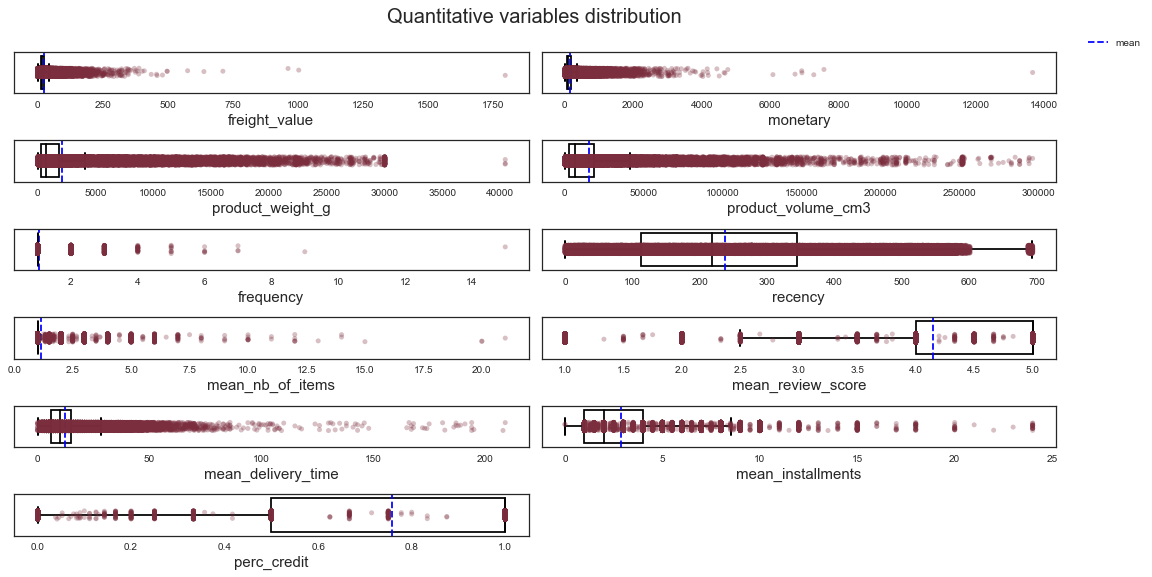

In [404]:
fig = plt.figure(figsize=(15, 8))
fig.suptitle('Quantitative variables distribution', fontsize=20, y=1.00)
for i, label in enumerate(quant):
    plt.subplot(6, 2, i+1)

    box = sns.boxplot(x=df[label],
                      color='white',
                      showfliers=False,
                      boxprops=dict(linestyle='-',
                                    edgecolor='black'),
                      medianprops=dict(linestyle='-',
                                       color='black'),
                      whiskerprops=dict(linestyle='-',
                                        color='black'),
                      capprops=dict(linestyle='-',
                                    linewidth=2.0,
                                    color='black')
                      )

    sns.stripplot(x=df[label],
                  color='#7B2E3E',
                  alpha=0.3)
    plt.axvline(df[label].mean(),
                color='blue',
                ls='--',
                label='mean' if i == 0 else '')
    plt.xlabel(label, fontsize=15)

fig.legend(bbox_to_anchor=(1.07, 0.96))
plt.tight_layout()
plt.savefig('Numerical_boxplot.png', transparent=True, bbox_inches='tight')
plt.show()

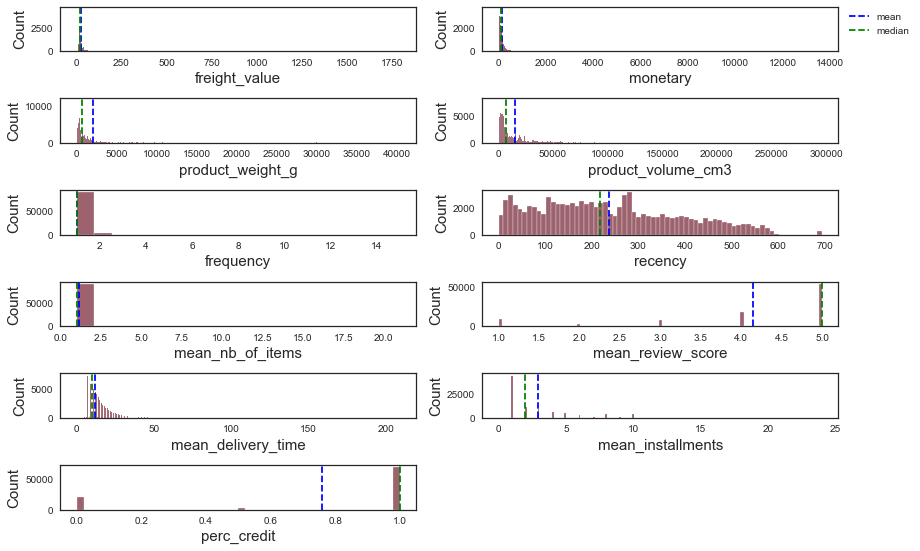

In [405]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle('', fontsize=20, y=1.05)
for i, label in enumerate(quant):
    plt.subplot(6, 2, i+1)
    sns.histplot(x=df[label], color='#7B2E3E')
    plt.axvline(df[label].mean(), color='blue', ls='--',
                label='mean' if i == 0 else '')
    plt.axvline(df[label].median(), color='green', ls='--',
                label='median' if i == 0 else '')
    plt.xlabel(label, fontsize=15)
    plt.ylabel('Count', fontsize=15)
fig.legend(bbox_to_anchor=(1.07, 0.96))
plt.tight_layout()
plt.savefig('Histplot1.png', transparent=True, bbox_inches='tight')
plt.show()

In [406]:
for i in quant:
    print(f'Skewness of {i} is {str(round(df[i].skew(), 2))}')

Skewness of freight_value is 11.85
Skewness of monetary is 9.21
Skewness of product_weight_g is 3.61
Skewness of product_volume_cm3 is 4.09
Skewness of frequency is 11.09
Skewness of recency is 0.45
Skewness of mean_nb_of_items is 7.63
Skewness of mean_review_score is -1.46
Skewness of mean_delivery_time is 3.88
Skewness of mean_installments is 1.61
Skewness of perc_credit is -1.2


<div class="alert alert-block alert-info">

Most features are right-skewed. A log transformation is therefore applied to some features in order to reduce skewness.
    
</div>

In [407]:
log_features = ['freight_value',
                'monetary',
                'product_weight_g',
                'product_volume_cm3',
                'frequency',
                'mean_nb_of_items',
                'mean_delivery_time',
                'mean_installments']

In [408]:
for i in log_features:
    df[i] = df[i].apply(lambda x: np.log(x+1))

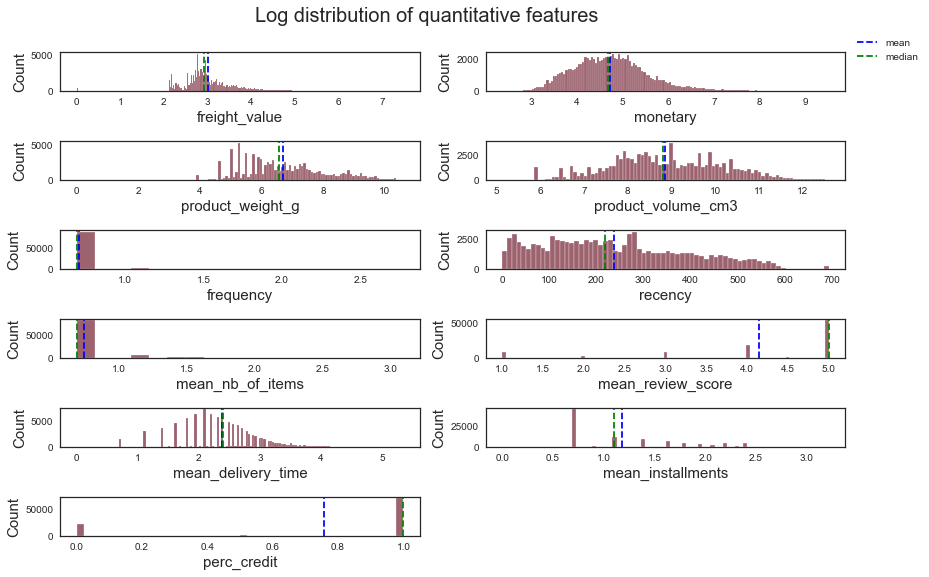

In [409]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle('Log distribution of quantitative features', fontsize=20, y=1.00)
for i, label in enumerate(quant):
    plt.subplot(6, 2, i+1)
    sns.histplot(df[label],
                 color='#7B2E3E')
    plt.axvline(df[label].mean(), color='blue', ls='--',
                label='mean' if i == 0 else '')
    plt.axvline(df[label].median(), color='green', ls='--',
                label='median' if i == 0 else '')
    plt.xlabel(label, fontsize=15)
    plt.ylabel('Count', fontsize=15)
fig.legend(bbox_to_anchor=(1.08, 0.96))
plt.tight_layout()
plt.savefig('Histplot2.png', transparent=True, bbox_inches='tight')
plt.show()

In [410]:
for i in quant:
    print(f'Skewness of {i} is {str(round(df[i].skew(), 2))}')

Skewness of freight_value is 0.46
Skewness of monetary is 0.53
Skewness of product_weight_g is 0.44
Skewness of product_volume_cm3 is 0.03
Skewness of frequency is 6.52
Skewness of recency is 0.45
Skewness of mean_nb_of_items is 3.98
Skewness of mean_review_score is -1.46
Skewness of mean_delivery_time is -0.08
Skewness of mean_installments is 0.81
Skewness of perc_credit is -1.2


<div class="alert alert-block alert-info">

Quantitative features skewness has been significantly reduced.    
</div>

In [411]:
df.to_csv('df_log.csv', index=False)

### 2.1.2 Categorical features

In [412]:
def countplot_ordered(i, title, xdim=10, ydim=6):
    fig, ax = plt.subplots(figsize=(xdim, ydim))
    ax = sns.countplot(data=df, y=i, color='#7B2E3E',
                       order=df[i].value_counts().index)

    container = ax.containers[0]
    df_len = len(df[i])
    ax.bar_label(container,
                 labels=[f'{x/df_len*100:.1f}%' for x in container.datavalues],
                 label_type='edge',
                 size=15,
                 color='black'
                 )
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.grid(axis='x', color='black', ls=':')

    plt.title(title, fontsize=20, y=1.02)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('Count', fontsize=15)
    plt.ylabel(f'{i}', fontsize=15)
    plt.tight_layout()
    plt.savefig(f'countplot_{i}.png', transparent=True, bbox_inches='tight')
    return plt.show()

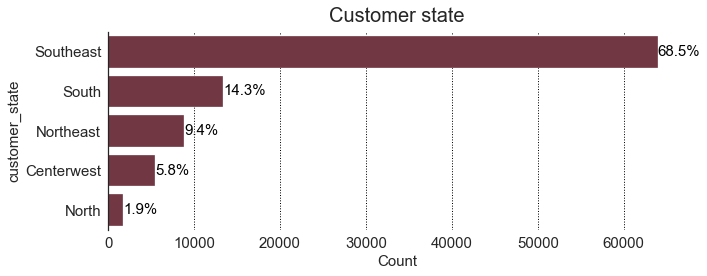

In [413]:
countplot_ordered('customer_state', 'Customer state', xdim=10, ydim=4)

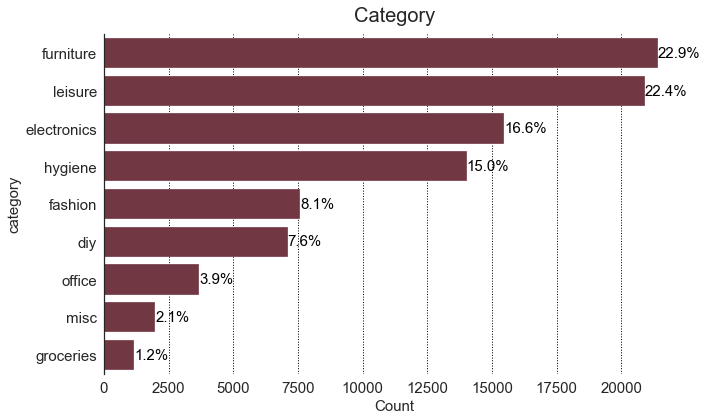

In [414]:
countplot_ordered('category', 'Category', xdim=10, ydim=6)

def countplot(i, title, xdim=10, ydim=6, order=None):
    fig, ax = plt.subplots(figsize=(xdim, ydim))
    ax = sns.countplot(data=df, y=i, color='#7B2E3E', order=order)

    container = ax.containers[0]
    df_len = len(df[i])
    ax.bar_label(container,
                 labels=[f'{x/df_len*100:.1f}%' for x in container.datavalues],
                 label_type='edge',
                 size=15,
                 color='black'
                 )
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.grid(axis='x', color='black', ls=':')

    plt.title(title, fontsize=20, y=1.02)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('Count', fontsize=15)
    plt.ylabel(f'{i}', fontsize=15)
    plt.tight_layout()
    plt.savefig(f'countplot_{i}.png', transparent=True, bbox_inches='tight')
    return plt.show()

order = [5, 4, 3, 2, 1]
countplot('review_score', 'Review score', xdim=10, ydim=4, order=order)

order = ['48h', '3 to 6 days', '1 to 2 weeks', '3 weeks to 1 month',
         'more than 1 month']
countplot('delivery_time', 'Delivery time', xdim=10, ydim=4, order=order1)

In [415]:
date_purchase = df.groupby(pd.Grouper(key='date_purchase', freq='w')).size()

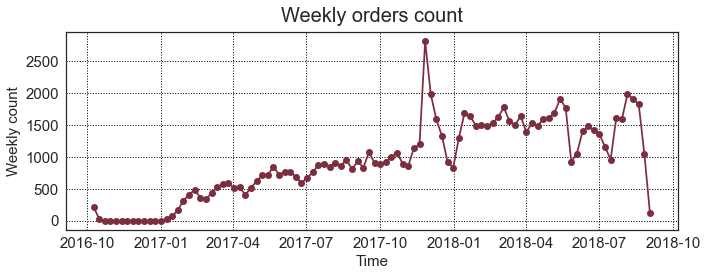

In [416]:
plt.subplots(figsize=(10, 4))
plt.plot(date_purchase, marker='o', color='#7B2E3E')
plt.grid(color='black', ls=':')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Weekly count', fontsize=15)
plt.title('Weekly orders count', fontsize=20, y=1.02)
plt.tight_layout()
plt.savefig('weekly_order_count.png', transparent=True, bbox_inches='tight')

## <a name="C2.2">2.2 Multivariate analysis</a>

In [38]:
quant

['freight_value',
 'monetary',
 'product_weight_g',
 'product_volume_cm3',
 'frequency',
 'recency',
 'mean_nb_of_items',
 'mean_review_score',
 'mean_delivery_time',
 'mean_installments',
 'perc_credit']

###  2.2.1 Correlation matrix

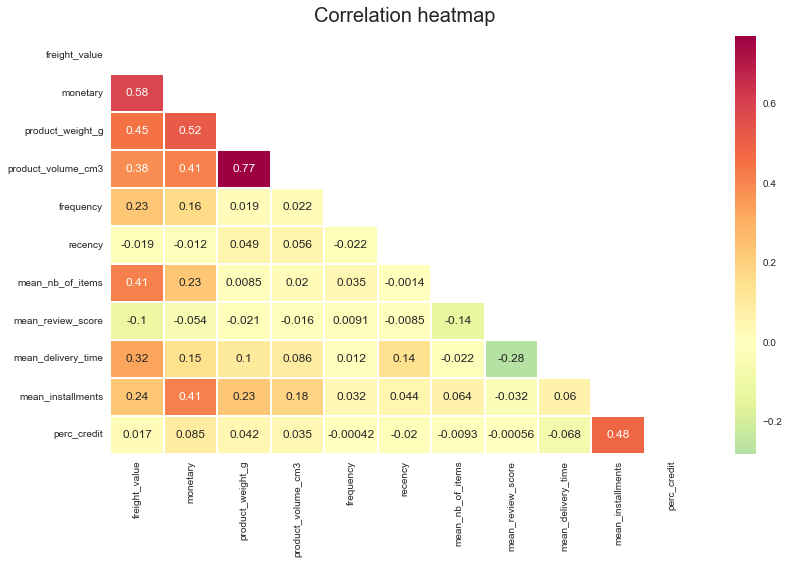

In [418]:
plt.subplots(figsize=(12, 8))
corr = df[quant].corr()

ax = sns.heatmap(corr,
                 annot=True,
                 cmap="Spectral_r",
                 center=0,
                 linewidths=2,
                 mask=np.triu(corr))
ax.set_title('Correlation heatmap', y=1.02, fontsize=20)
plt.tight_layout()
plt.savefig('Correlation_heatmap.png', transparent=True, bbox_inches='tight')
plt.show()

###  2.2.2 PCA

In [39]:
# Number of components
n_comp = 11

# Features selection
data_pca = df[quant]

# Prepare data for PCA
# data_pca = data_pca.fillna(data_pca.mean())
X_pca = data_pca.values
names = data_pca.index  # or data.index to get labels
features = data_pca.columns

# Standardize features by removing the mean and scaling to unit variance
std_scale = StandardScaler().fit(X_pca)
X_scaled = std_scale.transform(X_pca)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=11)

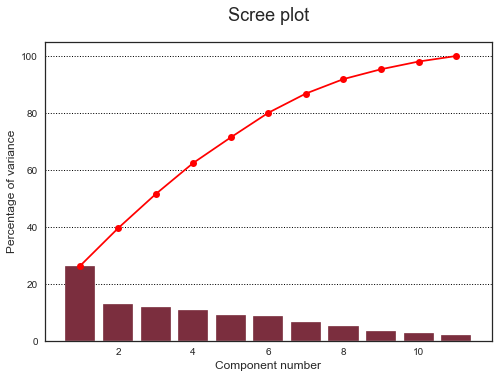

In [40]:
# Scree plot of eigenvalues

def display_scree_plot2(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree, color='#7B2E3E')
    plt.plot(np.arange(len(scree))+1, scree.cumsum(), c='red', marker='o')
    plt.xlabel('Component number', fontsize=12)
    plt.ylabel('Percentage of variance', fontsize=12)
    plt.grid(axis='y', color='black', ls=':')
    plt.title('Scree plot', fontsize=18, y=1.05)
    plt.savefig('scree_plot.png', transparent=True, bbox_inches='tight')
    plt.show(block=False)


display_scree_plot2(pca)

In [41]:
# Correlation circle

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None,
                    label_rotation=0, lims=None):
    for d1, d2 in axis_ranks:  # First 3 factorial planes are displayed
        if d2 < n_comp:

            fig, ax = plt.subplots(figsize=(6, 6))

            # Diagram limits
            if lims is not None:
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30:
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else:
                xmin, xmax, ymin, ymax = min(pcs[d1, :]), max(pcs[d1, :]),
                min(pcs[d2, :]), max(pcs[d2, :])

            # Showing arrows
            # If more than 30 arrows, tip is not shown
            if pcs.shape[1] < 30:
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                           pcs[d1, :], pcs[d2, :],
                           angles='xy', scale_units='xy',
                           scale=1, color="red", width=0.005)

            else:
                lines = [[[0, 0], [x, y]] for x, y in pcs[[d1, d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax,
                                                 alpha=.1, color='black'))

            # Displaying variables labels
            if labels is not None:
                for i, (x, y) in enumerate(pcs[[d1, d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax:
                        plt.text(x, y, labels[i], fontsize='14',
                                 ha='left', va='bottom',
                                 rotation=label_rotation,
                                 color="black", alpha=0.5)

            # Displaying circle
            circle = plt.Circle((0, 0), 1, facecolor='none', edgecolor='black')
            plt.gca().add_artist(circle)

            # Diagram limits
            plt.xlim(xmin-0.01, xmax+0.01)
            plt.ylim(ymin-0.01, ymax+0.01)

            # Horizontal and vertical lines display
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # Axes names, where percentage of variance is explained
            plt.xlabel('F{} ({}%)'
                       .format(d1+1, round(
                           100*pca.explained_variance_ratio_[d1], 1)),
                       fontsize=14)
            plt.ylabel('F{} ({}%)'
                       .format(d2+1, round(
                           100*pca.explained_variance_ratio_[d2], 1)),
                       fontsize=14)

            plt.title('Correlation circle for F{} and F{}'
                      .format(d1+1, d2+1), fontsize=18, y=1.05)
            plt.savefig('Correlation_circle_F{}_and_F{}'
                        .format(d1+1, d2+1),
                        transparent=True, bbox_inches='tight')
            plt.show(block=False)

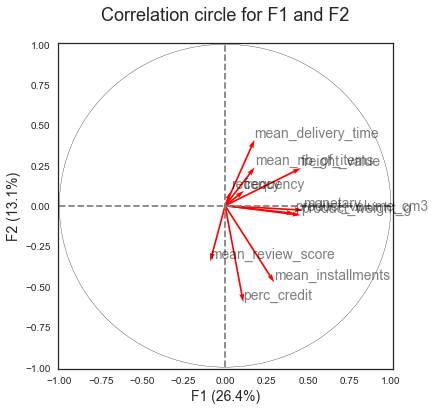

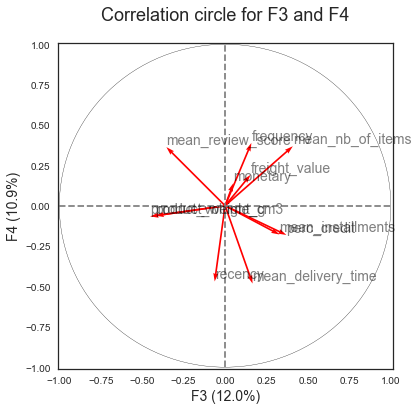

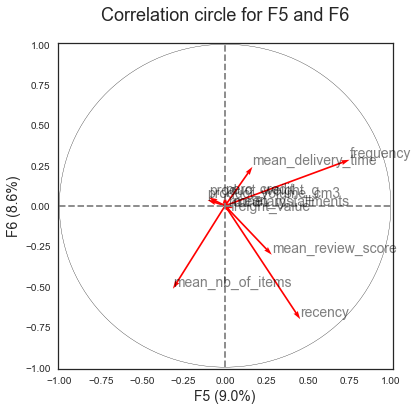

In [42]:
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0, 1), (2, 3), (4, 5)],
                labels=np.array(features))

In [43]:
# Projection on factorial planes

def display_factorial_planes(X_projected, n_comp, pca,
                             axis_ranks, labels=None, alpha=1):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:

            fig = plt.figure(figsize=(6, 6))

            # Scatterplot
#             palette = {'a':'#449B57', 'b':'#92BB47',
#             'c':'#F6CE46', 'd':'#E08831', 'e':'#D54B26'}
            sns.scatterplot(x=X_projected[:, d1],
                            y=X_projected[:, d2], alpha=alpha,
                            hue=df.monetary
                            )
# palette='tab10', hue_order=['a','b','c','d','e']
# plt.legend(bbox_to_anchor=(1.05, 0.5), loc=6, borderaxespad=0.)

            # Points label
            if labels is not None:
                for i, (x, y) in enumerate(X_projected[:, [d1, d2]]):
                    plt.text(x, y, labels[i],
                             fontsize='14', ha='center', va='center')

            # Diagram limits
            boundary = np.max(np.abs(X_projected[:, [d1, d2]])) * 1.1
            plt.xlim([-boundary, boundary])
            plt.ylim([-boundary, boundary])

            # Horizontal and vertical lines display
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # Axes names, where percentage of variance is explained
            plt.xlabel('F{} ({}%)'
                       .format(d1+1,
                               round(100*pca.explained_variance_ratio_[d1],
                                     1)),
                       fontsize=14)
            plt.ylabel('F{} ({}%)'
                       .format(d2+1,
                               round(100*pca.explained_variance_ratio_[d2],
                                     1)),
                       fontsize=14)

            plt.title('Projection of points on F{} and F{}'
                      .format(d1+1, d2+1), fontsize=18, y=1.05)
            plt.savefig('Projection_of_points_on_F{}_and_F{}'
                        .format(d1+1, d2+1), transparent=True,
                        bbox_inches='tight')
            plt.show(block=False)

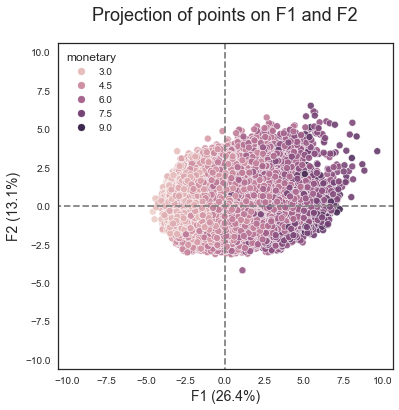

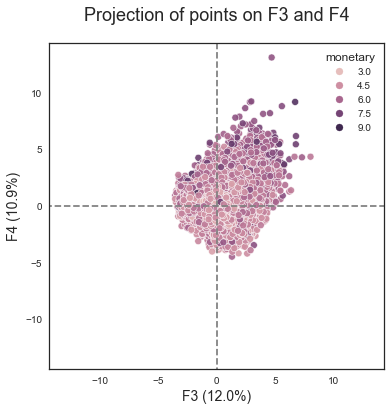

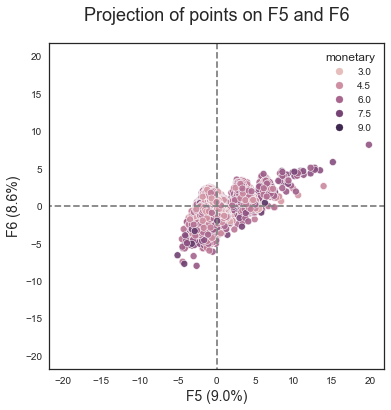

In [44]:
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca,
                         [(0, 1), (2, 3), (4, 5)], alpha=0.9)

In [419]:
df.head()

,ID,frequency,customer_state,freight_value,perc_credit,mean_installments,monetary,category,product_weight_g,product_volume_cm3,mean_nb_of_items,mean_review_score,date_purchase,mean_delivery_time,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,0.693147,Southeast,2.564949,1.0,2.197225,4.962145,furniture,7.313887,8.938138,0.693147,5.0,2018-05-10 10:56:27,1.945910,111
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.693147,Southeast,2.228939,1.0,0.693147,3.338967,hygiene,5.929589,8.546558,0.693147,4.0,2018-05-07 11:11:27,1.386294,114
2,0000f46a3911fa3c0805444483337064,0.693147,South,2.902520,1.0,2.197225,4.468434,office,7.313887,10.686270,0.693147,3.0,2017-03-10 21:05:03,3.258097,536
3,0000f6ccb0745a6a4b88665a16c9f078,0.693147,North,2.924773,1.0,1.609438,3.798182,electronics,5.017280,6.952729,0.693147,4.0,2017-10-12 20:29:41,3.044522,320
4,0004aac84e0df4da2b147fca70cf8255,0.693147,Southeast,2.884242,1.0,1.945910,5.287711,electronics,8.707979,6.270988,0.693147,5.0,2017-11-14 19:45:42,2.639057,287


### 2.2.3 Boxplot

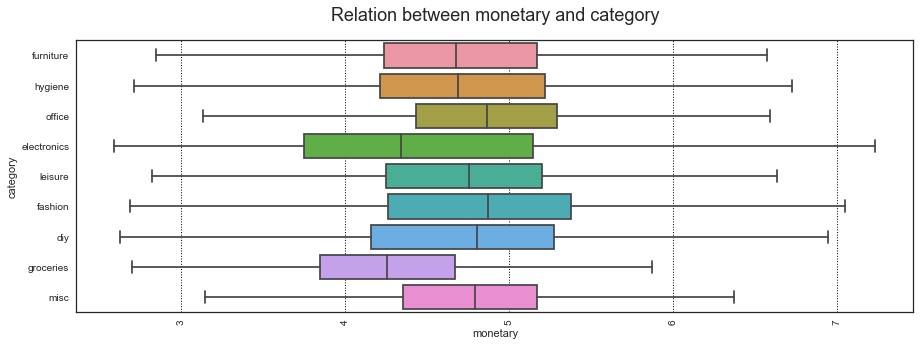

In [421]:
fig = plt.figure(figsize=(15, 5))
sns.boxplot(x=df['monetary'], y=df['category'], showfliers=False)
plt.xticks(rotation=90)
plt.grid(axis='x', color='black', ls=':')
plt.title('Relation between monetary and category',
          fontsize=18, y=1.05)
plt.savefig('Boxplot_1',
            transparent=True, bbox_inches='tight')
plt.show()

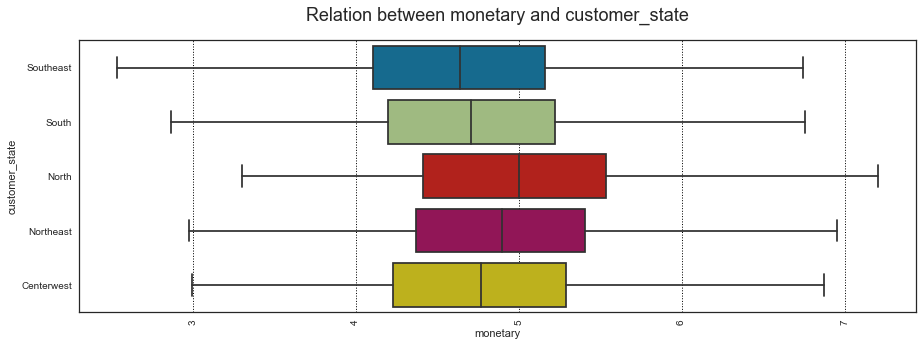

In [424]:
fig = plt.figure(figsize=(15, 5))
sns.boxplot(x=df['monetary'], y=df['customer_state'], showfliers=False)
plt.xticks(rotation=90)
plt.grid(axis='x', color='black', ls=':')
plt.title('Relation between monetary and customer_state',
          fontsize=18, y=1.05)
plt.savefig('Boxplot_1',
            transparent=True, bbox_inches='tight')
plt.show()

In [431]:
def eta_squared(x, y):
    mean_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x == classe]
        classes.append({'ni': len(yi_classe),
                        'class_mean': yi_classe.mean()})
    # Explained Sum of Squares (ESS = SCE)
    ESS = sum([c['ni']*(c['class_mean']-mean_y)**2 for c in classes])
    # Total Sum of Squares (TSS = SST = SCT)
    TSS = sum([(yj-mean_y)**2 for yj in y])
    return ESS/TSS

In [442]:
ANOVA_features = []
ANOVA_result = []

df_anova = df[quant]

k = 0
for j in list(qual):
    ANOVA_result = []
    for i in list(df_anova.columns):
        ANOVA_features.append(i)
        ANOVA_result.append(eta_squared(df[j], df_anova[i]))
    if k == 0:
        anova = pd.DataFrame(ANOVA_features, columns=['Numerical_features'])
    k += 1
    anova[j] = ANOVA_result
cm = sns.light_palette('#7B2E3E', as_cmap=True)
anova_styled = anova.style.background_gradient(cmap=cm, axis=None)
# https://pandas.pydata.org/docs/user_guide/style.html

dfi.export(anova_styled, 'mytable.png')

[0501/164027.249374:INFO:headless_shell.cc(660)] Written to file /var/folders/sj/st52tvf971ngjhz8ft3l9_tr0000gn/T/tmpw5pzbk0g/temp.png.


# <a name='C3'>3. RFM segmentation</a>

## 3.1 Selection of relevant variables

In [45]:
df_rfm = df[['recency', 'frequency', 'monetary']].copy()

In [46]:
df_rfm.head()

,recency,frequency,monetary
0,111,0.693147,4.962145
1,114,0.693147,3.338967
2,536,0.693147,4.468434
3,320,0.693147,3.798182
4,287,0.693147,5.287711


## 3.2 Normalization of selected variables

In [47]:
scaler = StandardScaler()
scaler.fit(df_rfm)
RFM_Table_scaled = scaler.transform(df_rfm)

df_rfm_n = pd.DataFrame(RFM_Table_scaled, # index=df.ID,
                        columns=df_rfm.columns)

5:42: E261 at least two spaces before inline comment


In [48]:
df_rfm_n.head()

,recency,frequency,monetary
0,-0.825425,-0.170198,0.288263
1,-0.805763,-0.170198,-1.719699
2,1.959963,-0.170198,-0.322486
3,0.544331,-0.170198,-1.151624
4,0.328053,-0.170198,0.691006


In [49]:
df_rfm_n.recency.describe()

count    9.334900e+04
mean    -5.618134e-17
std      1.000005e+00
min     -1.552903e+00
25%     -8.123172e-01
50%     -1.241626e-01
75%      7.081769e-01
max      2.995472e+00
Name: recency, dtype: float64

## 3.3 RFM segmentation based on tiers

In [50]:
# Note: log and normalization are not necessary for this segmentation method

In [51]:
# Not enough recurring customers to divide customers in more than 2 groups:
# customers with 1 order, and customers with more than 1 order

In [52]:
df_rfm_n['R_score'] = pd.cut(df_rfm_n['recency'],
                             bins=[df_rfm_n['recency'].min(),
                                   np.percentile(df_rfm_n['recency'], 25),
                                   np.percentile(df_rfm_n['recency'], 50),
                                   np.percentile(df_rfm_n['recency'], 75),
                                   df_rfm_n['recency'].max()],
                             labels=[1, 2, 3, 4])

df_rfm_n['F_score'] = pd.cut(df_rfm_n['frequency'],
                             bins=[-np.inf,
                                   df_rfm_n['frequency'].min(),
                                   df_rfm_n['frequency'].max()],
                             labels=[2, 1])

df_rfm_n['M_score'] = pd.cut(df_rfm_n['monetary'],
                             bins=[df_rfm_n['monetary'].min(),
                                   np.percentile(df_rfm_n['monetary'], 25),
                                   np.percentile(df_rfm_n['monetary'], 50),
                                   np.percentile(df_rfm_n['monetary'], 75),
                                   df_rfm_n['monetary'].max()],
                             labels=[4, 3, 2, 1])

In [53]:
df_rfm_n.head()

,recency,frequency,monetary,R_score,F_score,M_score
0,-0.825425,-0.170198,0.288263,1,2,2
1,-0.805763,-0.170198,-1.719699,2,2,4
2,1.959963,-0.170198,-0.322486,4,2,3
3,0.544331,-0.170198,-1.151624,3,2,4
4,0.328053,-0.170198,0.691006,3,2,1


In [54]:
def rfm_segments(df):
    if df['R_score'] == 1 and df['F_score'] == 1 and df['M_score'] == 1:
        return 'Best customers'
    elif df['R_score'] == 1 and df['F_score'] == 2 and df['M_score'] <= 2:
        return 'High-spending New Customers'
    elif df['R_score'] == 1 and df['F_score'] == 1 and df['M_score'] >= 3:
        return 'Lowest-Spending Active Loyal Customers'
    elif df['R_score'] == 4 and df['F_score'] <= 2 and df['M_score'] <= 2:
        return 'Churned Best Customers'
    else:
        return 'Other'

Best Customers – 1-1-1: transacted recently, do so often and spend more than other customers.

High-spending New Customers – 1-2-1 and 1-2-2: transacted only once, but very recently and spent a lot.

Lowest-Spending Active Loyal Customers – 1-1-3 and 1-1-4: transacted recently and do so often, but spend the least.

Churned Best Customers – 4-1-1, 4-1-2, 4-2-1 and 4-2-2: transacted frequently and spent a lot, but it’s been a long time since they’ve transacted.

In [55]:
df_rfm_n['RFM_score'] = df_rfm_n.apply(rfm_segments, axis=1)

In [56]:
df_rfm_n.RFM_score.value_counts()

Other                                     70208
High-spending New Customers               11294
Churned Best Customers                    11241
Best customers                              519
Lowest-Spending Active Loyal Customers       87
Name: RFM_score, dtype: int64

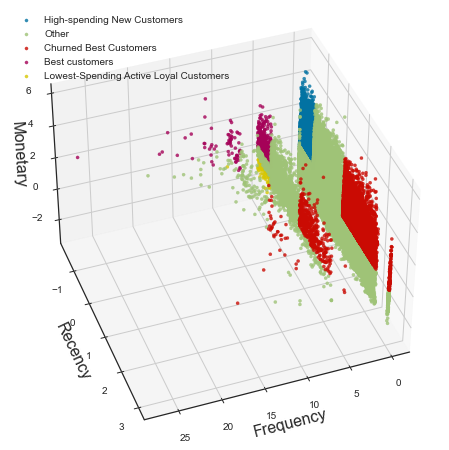

In [443]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection='3d')

for i, cluster in enumerate(df_rfm_n['RFM_score'].unique()):
    ax.scatter(df_rfm_n[df_rfm_n['RFM_score'] == cluster].frequency,
               df_rfm_n[df_rfm_n['RFM_score'] == cluster].recency,
               df_rfm_n[df_rfm_n['RFM_score'] == cluster].monetary,
               alpha=0.8,
               label=cluster,
               s=10
               )

ax.view_init(elev=40, azim=70)
ax.set_xlabel('Frequency', fontsize=16)
ax.set_ylabel('Recency', fontsize=16)
ax.set_zlabel('Monetary', fontsize=16)

plt.legend()
plt.show()

In [58]:
df_rfm_n.head()

,recency,frequency,monetary,R_score,F_score,M_score,RFM_score
0,-0.825425,-0.170198,0.288263,1,2,2,High-spending New Customers
1,-0.805763,-0.170198,-1.719699,2,2,4,Other
2,1.959963,-0.170198,-0.322486,4,2,3,Other
3,0.544331,-0.170198,-1.151624,3,2,4,Other
4,0.328053,-0.170198,0.691006,3,2,1,Other


<div class="alert alert-block alert-info">

The lack of frequency diversity, i.e. lack of customers that have several orders, limits the relevance of the conventional RFM analysis.
    
</div>

## Snake plot

In [59]:
df_rfm_n['ID'] = df['ID']

melt = pd.melt(df_rfm_n,
               id_vars=['ID', 'RFM_score'],
               value_vars=['recency', 'frequency', 'monetary'],
               var_name='Metric',
               value_name='Value'
               )

melt.head()

,ID,RFM_score,Metric,Value
0,0000366f3b9a7992bf8c76cfdf3221e2,High-spending New Customers,recency,-0.825425
1,0000b849f77a49e4a4ce2b2a4ca5be3f,Other,recency,-0.805763
2,0000f46a3911fa3c0805444483337064,Other,recency,1.959963
3,0000f6ccb0745a6a4b88665a16c9f078,Other,recency,0.544331
4,0004aac84e0df4da2b147fca70cf8255,Other,recency,0.328053


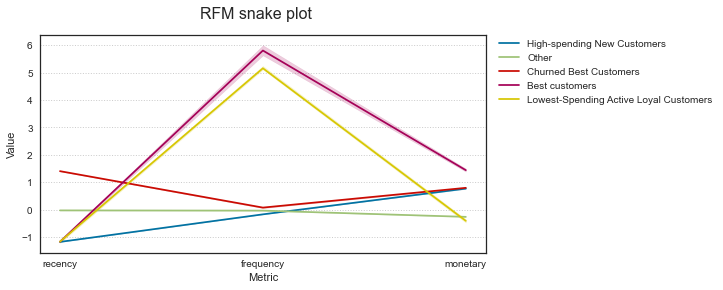

In [60]:
fig = plt.figure(figsize=(8, 4))

sns.color_palette("tab10")
sns.lineplot(x='Metric',
             y='Value',
             hue='RFM_score',
             data=melt).grid(axis='y', ls=':')
# ax.set_ylim([-2, 8])
plt.legend(bbox_to_anchor=(1.02, 1),
           loc='upper left',
           borderaxespad=0)

plt.suptitle('RFM snake plot', fontsize=16)
plt.show()

In [61]:
# segments table
# https://towardsdatascience.com/an-rfm-customer-segmentation-with-python-cf7be647733d
# https://www.optimove.com/resources/learning-center/rfm-segmentation

In [62]:
# 3D plot
# https://medium.com/web-mining-is688-spring-2021/exploring-customers-segmentation-with-rfm-analysis-and-k-means-clustering-118f9ffcd9f0

In [63]:
# snake plot
# https://medium.com/web-mining-is688-spring-2021/using-k-means-to-segment-customers-based-on-rfm-variables-9d4d683688c8

# <a name='C4'>4. Selection of more features as an alternative to RFM</a>

## <a name='C4.1'>4.1 Sampling</a>

<div class="alert alert-block alert-info">

Given the fact that below algorithms take significant time to converge, a sample is taken for the calculation.
    
</div>

In [64]:
df_init = df.copy()

In [65]:
df = df.sample(n=10000, random_state=42)

## <a name='C4.2'>4.2 Features selection</a>

In [66]:
df_rfm = df[['monetary',
             'frequency',
             'recency',
             'perc_credit',
             'mean_review_score',
             'mean_nb_of_items',
             'product_weight_g']].copy()

## <a name='C4.3'>4.3 Normalization of selected variables</a>

In [67]:
scaler = StandardScaler()
scaler.fit(df_rfm)
table_scaled = scaler.transform(df_rfm)

df_n = pd.DataFrame(table_scaled,  # index=df.ID,
                    columns=df_rfm.columns)

In [68]:
X = df_n.copy()

## <a name='C4.4'>4.4 K-means clustering</a>

### 4.4.1 Elbow method

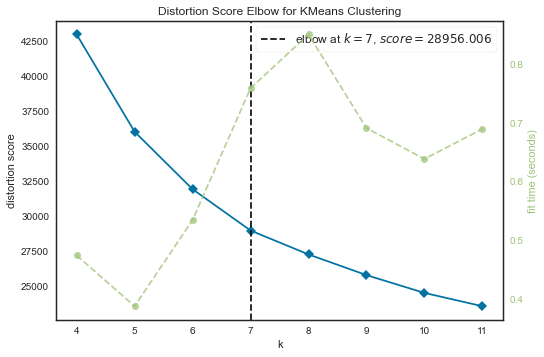

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [564]:
# Instantiate the clustering model and visualizer

# By default, the scoring parameter metric is set to distortion,
# which computes the sum of squared distances from each point
# to its assigned center.
model = KMeans(init='k-means++', random_state=1)
visualizer = KElbowVisualizer(model, k=(4, 12))

visualizer.fit(X)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

### 4.4.2 Clustering metrics

In [565]:
def clustering_metrics_kmeans(X, k_min, k_max, ARI_iter=10):

    inertia = []
    predict_time = []
    silhouette = []
    davies = []

    # ARI
    ARI = {}
    ARI_mean = []
    ARI_std = []
    cluster_table = pd.DataFrame()

    for k in range(k_min, k_max+1):

        model = KMeans(n_clusters=k,
                       init='k-means++',
                       random_state=1)

        start = time.time()
        cluster_labels = model.fit_predict(X)
        end = time.time()

        predict_time.append(end - start)
        inertia.append(model.inertia_)
        silhouette.append(silhouette_score(X, cluster_labels))
        davies.append(davies_bouldin_score(X, cluster_labels))

        # ARI
        cluster_table['nb_clusters_' + str(k)] = cluster_labels
        ARI[k] = []
        for n_it in range(ARI_iter):
            model_it = KMeans(n_clusters=k,
                              init='k-means++',
                              random_state=n_it)
            cluster_labels = model_it.fit_predict(X)
            ARI[k].append(
                adjusted_rand_score(cluster_table['nb_clusters_' + str(k)],
                                    cluster_labels))
        ARI_std.append(np.std(ARI[k]))
        ARI_mean.append(np.mean(ARI[k]))

    return inertia, predict_time, silhouette, ARI_std, ARI_mean, davies

In [566]:
inertia, predict_time, silhouette, ARI_std, ARI_mean, davies =\
    clustering_metrics_kmeans(X, 5, 8, ARI_iter=10)

In [606]:
def Metrics_visualization(silhouette, ARI_std, ARI_mean, davies, k_min, k_max):
    k_list = []
    for k in range(k_min, k_max+1):
        k_list.append(k)

    plt.figure(figsize=(15, 4.7))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle('Metrics visualization', fontsize=18, y=1.02)

    ax1 = plt.subplot(1, 3, 1)
    sns.barplot(x=k_list, y=silhouette, color='#7B2E3E')
    container1 = ax1.containers[0]
    ax1.bar_label(container1,
                  labels=[f'{x:.2f}' for x in container1.datavalues],
                  label_type='edge',
                  size=15,
                  color='black'
                  )
    ax1.set_ylim([0, 0.4])
    ax1.set_title('Silhouette', size=16)

    ax2 = plt.subplot(1, 3, 2)
    sns.barplot(x=k_list, y=ARI_mean, color='#7B2E3E',
                # yerr=ARI_std
                )
    container2 = ax2.containers[0]
    ax2.bar_label(container2,
                  labels=[f'{x:.2f}' for x in container2.datavalues],
                  label_type='edge',
                  size=15,
                  color='black'
                  )
    ax2.set_ylim([0, 1.2])
    ax2.set_title('ARI', size=16)

    ax3 = plt.subplot(1, 3, 3)
    sns.barplot(x=k_list, y=davies, color='#7B2E3E')
    container3 = ax3.containers[0]
    ax3.bar_label(container3,
                  labels=[f'{x:.2f}' for x in container3.datavalues],
                  label_type='edge',
                  size=15,
                  color='black'
                  )
    ax3.set_ylim([0, 1.5])
    ax3.set_title('Davies-Bouldin', size=16)

    return plt.show()

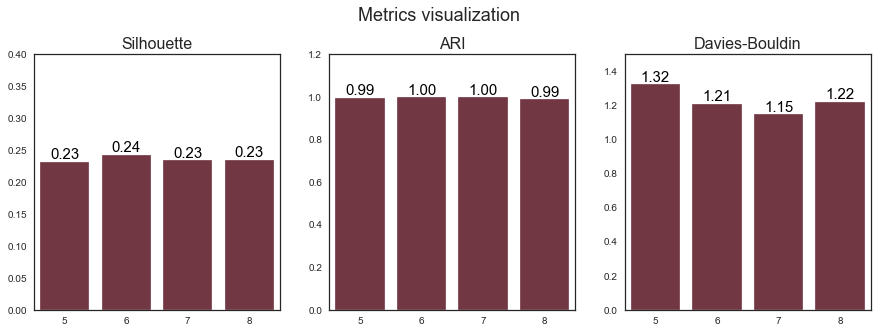

In [607]:
Metrics_visualization(silhouette, ARI_std, ARI_mean, davies, k_min=5, k_max=8)

<div class="alert alert-block alert-info">

In accordance to the elbow method with distortion above, k = 7 gives the best scores.
    
</div>

### 4.4.3 Clustering projections

In [345]:
def projection_kmeans(X, k_min, k_max):

    X_tsne = {}
    X_pca = {}
    X_umap = {}

    for k in range(k_min, k_max+1):
        model = KMeans(n_clusters=k,
                       init='k-means++',
                       random_state=1)
        cluster_labels = model.fit_predict(X)

        # TSNE
        tsne_reducer = TSNE(n_components=2,
                            learning_rate='auto',
                            init='random')
        X_trans_tsne = tsne_reducer.fit_transform(X)
        X_tsne[k] = pd.DataFrame(X_trans_tsne,  columns=['comp1', 'comp2'])
        X_tsne[k]['clusters'] = cluster_labels

        # PCA
        pca_reducer = decomposition.PCA(n_components=2)
        X_trans_pca = pca_reducer.fit_transform(X)
        X_pca[k] = pd.DataFrame(X_trans_pca,  columns=['comp1', 'comp2'])
        X_pca[k]['clusters'] = cluster_labels

        # UMAP
        umap_reducer = umap.UMAP()
        X_trans_umap = umap_reducer.fit_transform(X)
        X_umap[k] = pd.DataFrame(X_trans_umap,  columns=['comp1', 'comp2'])
        X_umap[k]['clusters'] = cluster_labels

    return X_tsne, X_pca, X_umap

In [445]:
X_tsne, X_pca, X_umap = projection_kmeans(X, 7, 7)

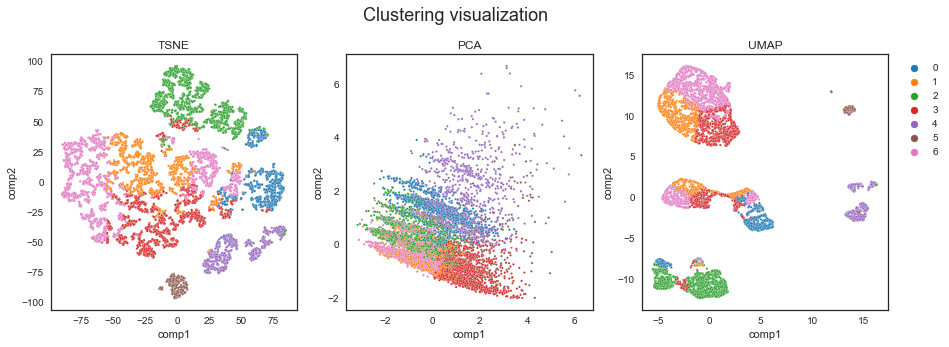

In [446]:
vis = [X_tsne, X_pca, X_umap]
lab = ['TSNE', 'PCA', 'UMAP']
k = 7

plt.figure(figsize=(15, 4.7))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Clustering visualization', fontsize=18, y=1.02)

for n, label in enumerate(vis):
    ax = plt.subplot(1, 3, n + 1)
    sns.scatterplot(x=label[k]['comp1'],
                    y=label[k]['comp2'],
                    hue=label[k]['clusters'],
                    palette=sns.color_palette('tab10', k),
                    s=5)
    ax.set_title(lab[n])
    if n != 2:
        ax.get_legend().remove()
    else:
        ax.legend(bbox_to_anchor=(1.03, 1), loc='upper left')

## <a name='C4.5'>4.5 Hierarchical clustering = Agglomerative clustering</a>

### 4.5.1 Elbow method

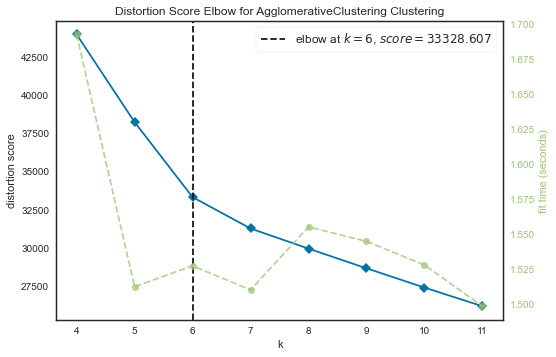

<AxesSubplot:title={'center':'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [141]:
model = AgglomerativeClustering(n_clusters=k,
                                affinity='euclidean',
                                linkage='ward')
visualizer = KElbowVisualizer(model, k=(4, 12))

visualizer.fit(X)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

### 4.5.2 Clustering metrics

In [142]:
def clustering_metrics_hierarchical(X, k_min, k_max, ARI_iter=10):

    predict_time = []
    silhouette = []
    davies = []

    # ARI
    ARI = {}
    ARI_mean = []
    ARI_std = []
    cluster_table = pd.DataFrame()

    for k in range(k_min, k_max+1):

        model = AgglomerativeClustering(n_clusters=k,
                                        affinity='euclidean',
                                        linkage='ward')

        start = time.time()
        cluster_labels = model.fit_predict(X)
        end = time.time()

        predict_time.append(end - start)
        silhouette.append(silhouette_score(X, cluster_labels))
        davies.append(davies_bouldin_score(X, cluster_labels))

        # ARI
        cluster_table['nb_clusters_' + str(k)] = cluster_labels
        ARI[k] = []
        for n_it in range(ARI_iter):
            model_it = KMeans(n_clusters=k,
                              init='k-means++',
                              random_state=n_it)
            cluster_labels = model_it.fit_predict(X)
            ARI[k].append(
                adjusted_rand_score(cluster_table['nb_clusters_' + str(k)],
                                    cluster_labels))
        ARI_std.append(np.std(ARI[k]))
        ARI_mean.append(np.mean(ARI[k]))

    return predict_time, silhouette, ARI_std, ARI_mean, davies

In [143]:
predict_time, silhouette, ARI_std, ARI_mean, davies =\
    clustering_metrics_hierarchical(X, 5, 8, ARI_iter=10)

In [144]:
def Metrics_visualization(silhouette, ARI_std, ARI_mean, davies, k_min, k_max):
    k_list = []
    for k in range(k_min, k_max+1):
        k_list.append(k)

    plt.figure(figsize=(15, 4.7))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle('Metrics visualization', fontsize=18, y=1.02)

    ax1 = plt.subplot(1, 3, 1)
    sns.barplot(x=k_list, y=silhouette, color='#7B2E3E')
    container1 = ax1.containers[0]
    ax1.bar_label(container1,
                  labels=[f'{x:.2f}' for x in container1.datavalues],
                  label_type='edge',
                  size=15,
                  color='black'
                  )
    ax1.set_ylim([0, 1])
    ax1.set_title('Silhouette', size=16)

    ax2 = plt.subplot(1, 3, 2)
    sns.barplot(x=k_list, y=ARI_mean, color='#7B2E3E',
                # yerr=ARI_std
                )
    container2 = ax2.containers[0]
    ax2.bar_label(container2,
                  labels=[f'{x:.2f}' for x in container2.datavalues],
                  label_type='edge',
                  size=15,
                  color='black'
                  )
    ax2.set_ylim([0, 1.2])
    ax2.set_title('ARI', size=16)

    ax3 = plt.subplot(1, 3, 3)
    sns.barplot(x=k_list, y=davies, color='#7B2E3E')
    container3 = ax3.containers[0]
    ax3.bar_label(container3,
                  labels=[f'{x:.2f}' for x in container3.datavalues],
                  label_type='edge',
                  size=15,
                  color='black'
                  )
    ax3.set_ylim([0, 1.5])
    ax3.set_title('Davies-Bouldin', size=16)

    return plt.show()

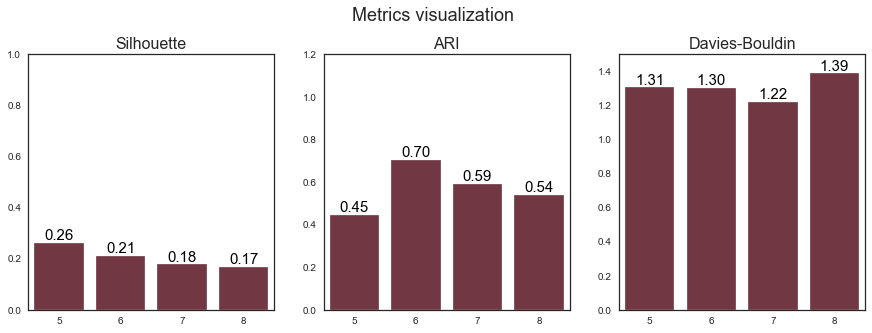

In [145]:
Metrics_visualization(silhouette, ARI_std, ARI_mean, davies, k_min=5, k_max=8)

### 4.5.3 Clustering projections

In [447]:
def projection_hierarchical(X, k_min, k_max):

    X_tsne = {}
    X_pca = {}
    X_umap = {}

    for k in range(k_min, k_max+1):
        model = AgglomerativeClustering(n_clusters=k,
                                        affinity='euclidean',
                                        linkage='ward')
        cluster_labels = model.fit_predict(X)

        # TSNE
        tsne_reducer = TSNE(n_components=2,
                            learning_rate='auto',
                            init='random')
        X_trans_tsne = tsne_reducer.fit_transform(X)
        X_tsne[k] = pd.DataFrame(X_trans_tsne,  columns=['comp1', 'comp2'])
        X_tsne[k]['clusters'] = cluster_labels

        # PCA
        pca_reducer = decomposition.PCA(n_components=2)
        X_trans_pca = pca_reducer.fit_transform(X)
        X_pca[k] = pd.DataFrame(X_trans_pca,  columns=['comp1', 'comp2'])
        X_pca[k]['clusters'] = cluster_labels

        # UMAP
        umap_reducer = umap.UMAP()
        X_trans_umap = umap_reducer.fit_transform(X)
        X_umap[k] = pd.DataFrame(X_trans_umap,  columns=['comp1', 'comp2'])
        X_umap[k]['clusters'] = cluster_labels

    return X_tsne, X_pca, X_umap

In [448]:
X_tsne, X_pca, X_umap = projection_hierarchical(X, 6, 6)

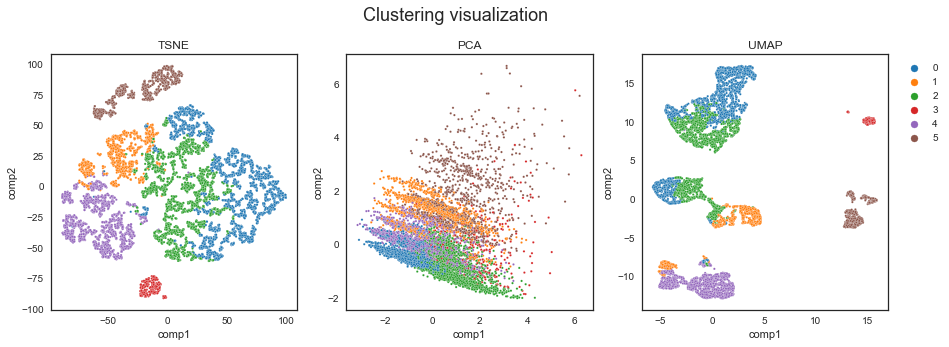

In [449]:
vis = [X_tsne, X_pca, X_umap]
lab = ['TSNE', 'PCA', 'UMAP']
k = 6

plt.figure(figsize=(15, 4.7))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Clustering visualization', fontsize=18, y=1.02)

for n, label in enumerate(vis):
    ax = plt.subplot(1, 3, n + 1)
    sns.scatterplot(x=label[k]['comp1'],
                    y=label[k]['comp2'],
                    hue=label[k]['clusters'],
                    palette=sns.color_palette('tab10', k),
                    s=5)
    ax.set_title(lab[n])
    if n != 2:
        ax.get_legend().remove()
    else:
        ax.legend(bbox_to_anchor=(1.03, 1), loc='upper left')

### 4.5.4 Dendogram plot

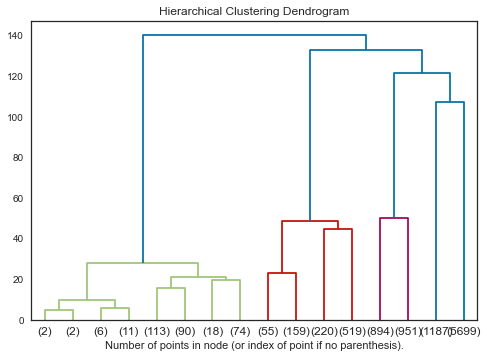

In [162]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

## <a name='C4.6'>4.6 DBScan clustering</a>

In [271]:
from clusteval import clusteval

In [273]:
# Set parameters, as an example dbscan
ce = clusteval('dbscan')

In [276]:
X2 = X.to_numpy()

In [277]:
# Fit to find optimal number of clusters using dbscan
results = ce.fit(X2)


[clusteval] >Fit using dbscan with metric: euclidean, and linkage: ward
[clusteval] >Gridsearch across epsilon..
[clusteval] >Evaluate using silhouette..


100%|█████████████████████████████████████████| 245/245 [06:48<00:00,  1.67s/it]
2:8: E225 missing whitespace around operator


[clusteval] >Compute dendrogram threshold.
[clusteval] >Optimal number clusters detected: [3].
[clusteval] >Fin.


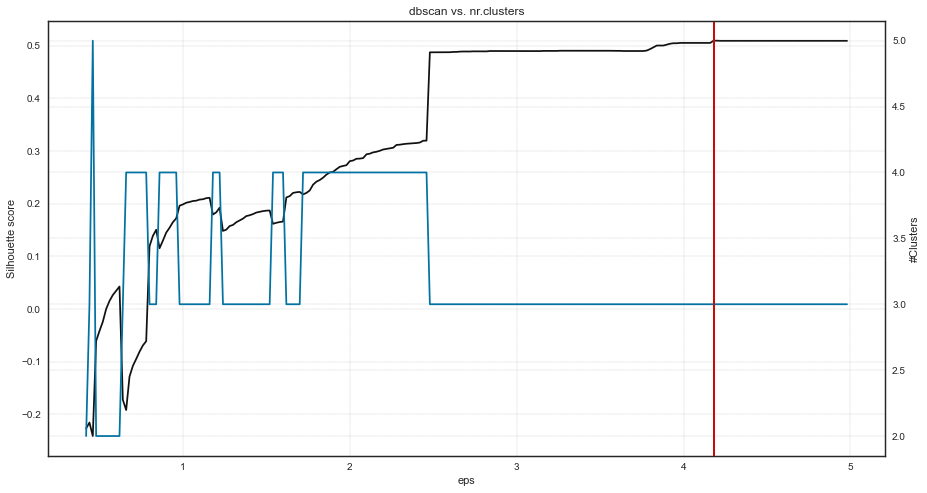

(<Figure size 1080x576 with 2 Axes>,
 (<AxesSubplot:title={'center':'dbscan vs. nr.clusters'}, xlabel='eps', ylabel='Silhouette score'>,
  <AxesSubplot:ylabel='#Clusters'>))

In [278]:
# Make plot of the cluster evaluation
ce.plot()

In [366]:
# results is a dict with various output statistics. One of them are the labels.
cluster_labels = results['labx']

### 4.6.1 Clustering metrics

In [303]:
def clustering_metrics_dbscan(X, ARI_iter=10):

    predict_time = []
    silhouette = []
    davies = []

    # ARI
    ARI = {}
    ARI_mean = []
    ARI_std = []
    cluster_table = pd.DataFrame()

    for eps in [1, 2, 3, 4, 5]:
        model = DBSCAN(eps=eps, min_samples=2)

        start = time.time()
        cluster_labels = model.fit_predict(X)
        end = time.time()

        predict_time.append(end - start)
        silhouette.append(silhouette_score(X, cluster_labels))
        davies.append(davies_bouldin_score(X, cluster_labels))

        # ARI
        cluster_table['eps_' + str(k)] = cluster_labels
        ARI[k] = []
        for n_it in range(ARI_iter):
            model_it = KMeans(n_clusters=k,
                              init='k-means++',
                              random_state=n_it)
            cluster_labels = model_it.fit_predict(X)
            ARI[k].append(
                adjusted_rand_score(cluster_table['eps_' + str(k)],
                                    cluster_labels))
        ARI_std.append(np.std(ARI[k]))
        ARI_mean.append(np.mean(ARI[k]))

    return predict_time, silhouette, ARI_std, ARI_mean, davies

In [297]:
predict_time, silhouette, ARI_std, ARI_mean, davies =\
    clustering_metrics_dbscan(X, ARI_iter=10)

In [316]:
def Metrics_visualization(silhouette, ARI_mean, davies, eps_min, eps_max):
    k_list = []
    for k in range(eps_min, eps_max+1):
        k_list.append(k)
    print(k_list)
    plt.figure(figsize=(15, 4.7))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle('Metrics visualization', fontsize=18, y=1.02)

    ax1 = plt.subplot(1, 3, 1)
    sns.barplot(x=k_list, y=silhouette, color='#7B2E3E')
    container1 = ax1.containers[0]
    ax1.bar_label(container1,
                  labels=[f'{x:.2f}' for x in container1.datavalues],
                  label_type='edge',
                  size=15,
                  color='black'
                  )
    ax1.set_ylim([0, 1])
    ax1.set_title('Silhouette', size=16)

    ax2 = plt.subplot(1, 3, 2)
    sns.barplot(x=k_list, y=ARI_mean, color='#7B2E3E',
                # yerr=ARI_std
                )
    container2 = ax2.containers[0]
    ax2.bar_label(container2,
                  labels=[f'{x:.2f}' for x in container2.datavalues],
                  label_type='edge',
                  size=15,
                  color='black'
                  )
    ax2.set_ylim([0, 1.2])
    ax2.set_title('ARI', size=16)

    ax3 = plt.subplot(1, 3, 3)
    sns.barplot(x=k_list, y=davies, color='#7B2E3E')
    container3 = ax3.containers[0]
    ax3.bar_label(container3,
                  labels=[f'{x:.2f}' for x in container3.datavalues],
                  label_type='edge',
                  size=15,
                  color='black'
                  )
    ax3.set_ylim([0, 2])
    ax3.set_title('Davies-Bouldin', size=16)

    return plt.show()

[1, 2, 3, 4, 5]


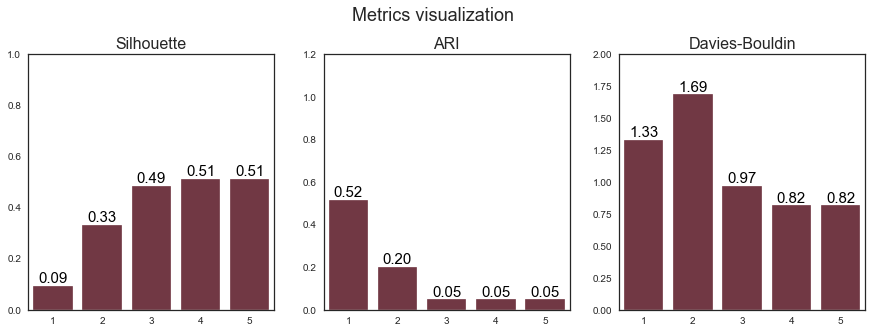

In [317]:
Metrics_visualization(silhouette, ARI_mean, davies, eps_min=1, eps_max=5)

### 4.6.2 Clustering projections

In [342]:
def projection_dbscan(X, eps_min, eps_max):

    X_tsne = {}
    X_pca = {}
    X_umap = {}

    for eps in range(eps_min, eps_max+1):
        model = DBSCAN(eps=eps, min_samples=2)
        cluster_labels = model.fit_predict(X)

        # TSNE
        tsne_reducer = TSNE(n_components=2,
                            learning_rate='auto',
                            init='random')
        X_trans_tsne = tsne_reducer.fit_transform(X)
        X_tsne[k] = pd.DataFrame(X_trans_tsne,  columns=['comp1', 'comp2'])
        X_tsne[k]['clusters'] = cluster_labels

        # PCA
        pca_reducer = decomposition.PCA(n_components=2)
        X_trans_pca = pca_reducer.fit_transform(X)
        X_pca[k] = pd.DataFrame(X_trans_pca,  columns=['comp1', 'comp2'])
        X_pca[k]['clusters'] = cluster_labels

        # UMAP
        umap_reducer = umap.UMAP()
        X_trans_umap = umap_reducer.fit_transform(X)
        X_umap[k] = pd.DataFrame(X_trans_umap,  columns=['comp1', 'comp2'])
        X_umap[k]['clusters'] = cluster_labels

    return X_tsne, X_pca, X_umap

In [368]:
X_tsne, X_pca, X_umap = projection_hierarchical(X, 3, 3)

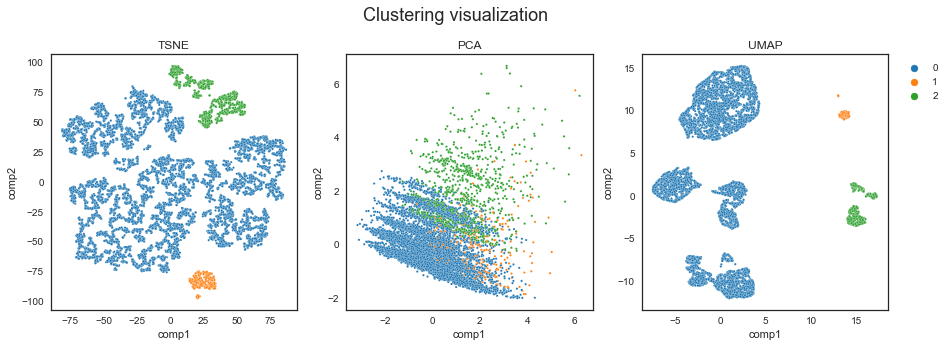

In [369]:
vis = [X_tsne, X_pca, X_umap]
lab = ['TSNE', 'PCA', 'UMAP']
k = 3

plt.figure(figsize=(15, 4.7))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Clustering visualization', fontsize=18, y=1.02)

for n, label in enumerate(vis):
    ax = plt.subplot(1, 3, n + 1)
    sns.scatterplot(x=label[k]['comp1'],
                    y=label[k]['comp2'],
                    hue=label[k]['clusters'],
                    palette=sns.color_palette('tab10', k),
                    s=5)
    ax.set_title(lab[n])
    if n != 2:
        ax.get_legend().remove()
    else:
        ax.legend(bbox_to_anchor=(1.03, 1), loc='upper left')

## <a name='C4.7'>4.7 Model selection and radar plot</a>

### 4.7.1 Model selection

<div class="alert alert-block alert-info">

K-means gives better ARI score, i.e. stability, it'll therefore be considered for the remaining studies.    
</div>

### 4.7.2 Radar plot

In [69]:
model = KMeans(n_clusters=7,
               init='k-means++',
               random_state=1)
cluster_labels = model.fit_predict(X)

In [70]:
X_radar = X.copy()
X_radar['group'] = cluster_labels
X_radar = X_radar.groupby(['group']).agg('mean')
X_radar = pd.DataFrame(MinMaxScaler().fit_transform(X_radar),
                       columns=list(X_radar.columns), index=X_radar.index)

In [71]:
X_radar['group'] = X_radar.index.astype(str)

In [72]:
X_radar

,monetary,frequency,recency,perc_credit,mean_review_score,mean_nb_of_items,product_weight_g,group
group,,,,,,,,
0,0.385442,0.00000,0.364149,0.808551,0.000000,0.003069,0.343768,0
1,0.169137,0.00000,1.000000,0.998836,0.989990,0.002816,0.202480,1
2,0.111681,0.00000,0.388312,0.000000,0.965487,0.005403,0.204036,2
3,1.000000,0.00000,0.280843,0.936703,0.987554,0.000000,1.000000,3
4,0.815618,0.00103,0.367778,0.760406,0.666655,1.000000,0.361530,4
5,0.934569,1.00000,0.337143,0.728492,0.854683,0.140396,0.405940,5
6,0.000000,0.00000,0.000000,1.000000,1.000000,0.000692,0.000000,6


In [111]:
cluster_names = ['Unsatisfied',
                 'New credit paying satisfied',
                 'Cash paying casual satisfied',
                 'Compulsive, few expensive items',
                 'Compulsive, many items',
                 'High value frequent buyer, to be reached',
                 'Credit paying casual satisfied'
                 ]

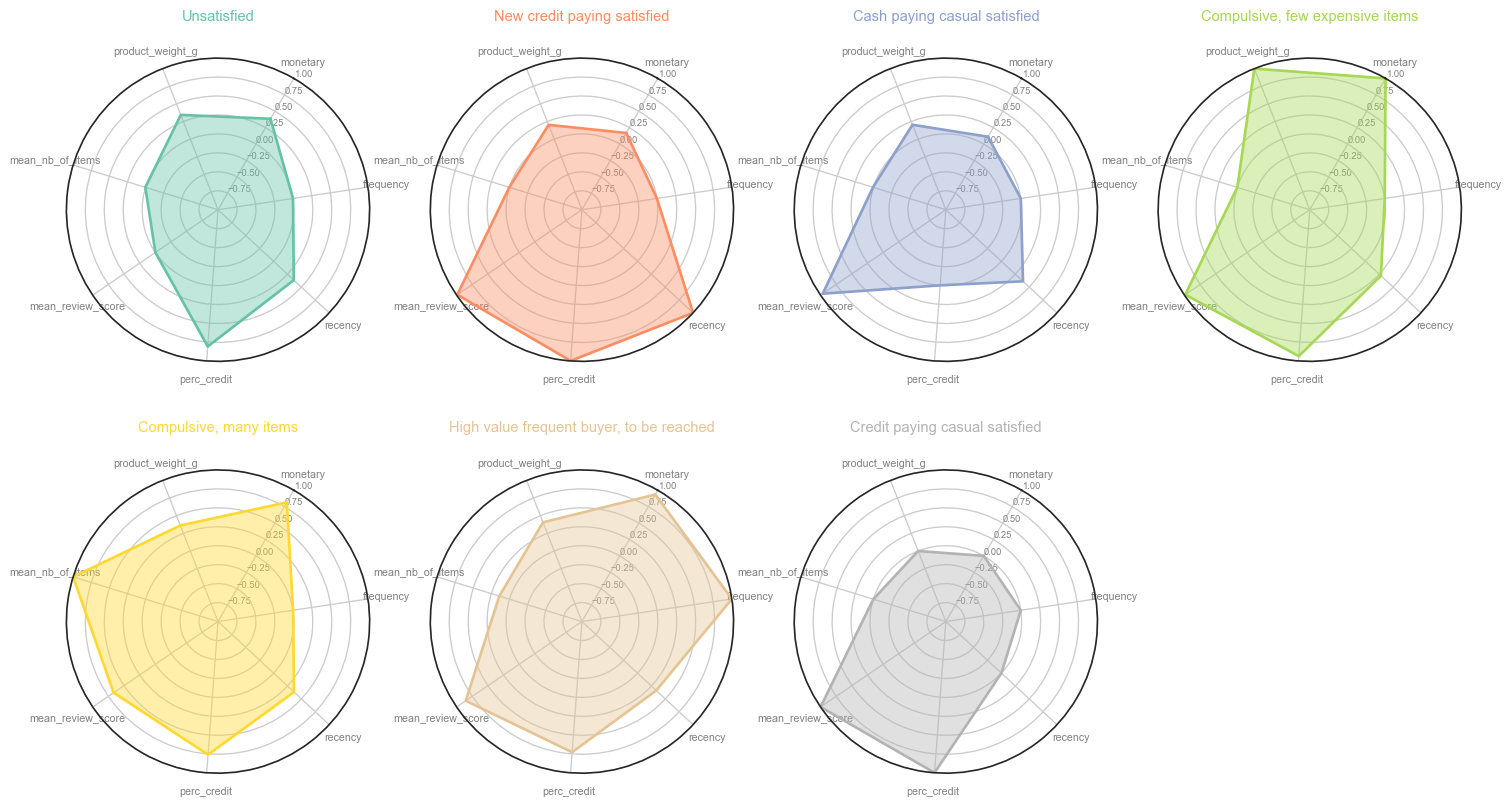

In [112]:
# https://python-graph-gallery.com/392-use-faceting-for-radar-chart

# Set data
df = X_radar

# ------- PART 1: Define a function that do a plot for one line of the dataset!


def make_spider(row, title, color):

    # number of variable
    categories = list(df)[0:-1]
    N = len(categories)

    # What will be the angle of each axis in the plot?
    # (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(2, 4, row+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 3)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks(color="grey", size=7)
    plt.ylim(-1, 1)

    # Ind1
    values = df.loc[row].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=11, color=color, y=1.1)


# ------- PART 2: Apply the function to all individuals
# initialize the figure
my_dpi = 96
plt.figure(figsize=(1800/my_dpi, 1000/my_dpi), dpi=my_dpi)

# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df.index))

# Loop to plot
for row in range(0, len(df.index)):
    make_spider(row=row, title=cluster_names[row],
                color=my_palette(row))

In [379]:
df_rfm.to_csv('df_rfm.csv', index=False)